In [206]:
import tensorflow as tf
from tensorflow import keras
import os

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Layer, MultiHeadAttention, Dense, Add, Conv2D, MaxPooling2D

from random import randint
import numpy as np
import matplotlib.pyplot as plt
from math import floor

from datetime import datetime

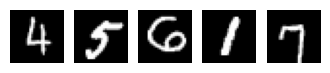

In [207]:
(xr, yr), (xe, ye) = mnist.load_data()
xr, xe = xr / 255.0, xe / 255.0
xr, xe = xr.reshape(-1, 28, 28, 1), xe.reshape(-1, 28, 28, 1)
yr, ye = to_categorical(yr), to_categorical(ye)



_, bs = plt.subplots(1, 5, figsize=(4, 4))
for b in bs:
    index = randint(0, len(xr))
    b.imshow(xr[index], cmap='gray')
    b.axis('off')

In [208]:
class fh(Sequential):
    def __init__(self, cn):
        super().__init__(
            [
                Conv2D(cn, 3, activation="relu", padding="same", name="fcv"),
                MaxPooling2D(2),
                Conv2D(cn, 3, activation="relu", padding="same"),
                MaxPooling2D(2),
                Conv2D(cn, 3, activation="relu", padding="same"),
            ]
        )
    
    def call(self, x):
        a = []
        for l in self.layers:
            x = l(x)
            if isinstance(l, Conv2D) and l.name != "fcv":
                a.append(tf.reshape(x, [-1, tf.reduce_prod(x.shape[1:])]))
        a = tf.concat(a, axis=1)
        return a



print(fh(4)(xr[:4]).shape)


(4, 980)


In [209]:
class fs(Sequential):
    def __init__(self, ex, os):
        super().__init__(
            [
                Dense(ex, activation="relu"),
                Dense(ex, activation="relu"),
                Dense(os),
            ]
        )

class ff(Sequential):
    def __init__(self, ex, em):
        super().__init__(
            [
                Dense(ex, activation="relu"),
                Dense(em),
            ]
        )

class tb(Layer):
    def __init__(self, em, he, ex):
        super().__init__()
        self.at = MultiHeadAttention(he, em)
        self.ff = ff(ex, em)
        self.ad = Add()

    def call(self, x): 
        ao = self.at(x, x)
        ro = self.ad([x, ao])
        fo = self.ff(ro)
        return self.ad([ro, fo])

class tm(Model):
    def __init__(self, ly, em, he, ex, cl, at):
        super().__init__()

        self.em = ff(ex, em)

        self.ct = self.add_weight(shape=(1, 1, em), name="ct")
        self.pt = self.add_weight(shape=(1, 1, em), name="pt")

        self.bl = []
        for _ in range(ly):
            self.bl.append(tb(em, he, ex))


        self.ch = fs(ex, cl)
        self.ph = fs(ex, at)

    def call(self, x):
        x = self.em(x)
        x = tf.concat([tf.tile(self.ct, [tf.shape(x)[0], 1, 1]), tf.tile(self.pt, [tf.shape(x)[0], 1, 1]), x], axis=1)
        for b in self.bl:
            x = b(x)
        return x
    
    def cls(self, x):
        return tf.nn.softmax(self.ch(self(x)[:, 0]), axis=1)

    def plc(self, x):
        return tf.nn.softmax(self.ph(self(x)[:, 1]), axis=1)



print ((lambda model, x: (str(model(x).shape), str(model.cls(x).shape), str(model.plc(x).shape)))(tm(16, 128, 4, 256, 10, 784), tf.random.uniform((4, 16, 784))))

('(4, 18, 128)', '(4, 10)', '(4, 784)')


In [349]:
class ml(Model):
    def __init__(self, ly=16, em=128, ex=256, he=4, cl=10, cn=4, sh=(28, 28, 1), il=16):
        super().__init__()
        self.fh = fh(cn)
        at = sum(floor(sh[0]/2**i)*floor(sh[1]/2**i) for i in range(1, 3)) * cn
        self.tm = tm(ly, em, he, ex, cl, at)
        self.ip = self.add_weight(shape=(at, il), name="ip")
        self.at = at
    def call(self, x):
        ac = self.fh(x)
        sip = tf.nn.softmax(self.ip, axis=0)
        
        ap = tf.concat([
            tf.transpose(
                tf.tile(
                    tf.expand_dims(sip, 0), [tf.shape(x)[0], 1, 1]
                    ), perm=[0, 2, 1]), 
            tf.expand_dims(tf.matmul(ac, sip), 2)
            ], axis=2)
        outs = []
        for _ in range(8):
            po = self.tm.plc(ap)
            ns = tf.concat([tf.expand_dims(po, 1), tf.reshape(tf.einsum('ij,ij->i', ac, po), (-1, 1, 1))], axis=2)
            ap = tf.concat([ap, ns], axis=1)
            outs.append(self.tm.cls(ap))
        out = tf.reduce_mean(tf.stack(outs), axis=0)
        return out

    def inf(self, x, r=1, q=False):
        ac = self.fh(x)
        sip = tf.nn.softmax(self.ip, axis=0)
        if q:
            sip = tf.transpose(zereno(tf.transpose(sip), k=32))
        ap = tf.concat([
            tf.transpose(
                tf.tile(
                    tf.expand_dims(sip, 0), [tf.shape(x)[0], 1, 1]
                    ), perm=[0, 2, 1]), 
            tf.expand_dims(tf.matmul(ac, sip), 2)
            ], axis=2)
        outs = []
        for _ in range(r):
            po = self.tm.plc(ap)
            if q:
                po = zereno(po, k=20)
            ns = tf.concat([tf.expand_dims(po, 1), tf.reshape(tf.einsum('ij,ij->i', ac, po), (-1, 1, 1))], axis=2)
            ap = tf.concat([ap, ns], axis=1)
            outs.append(self.tm.cls(ap))
        return outs

def zereno(softmax_batch, k=8):
    # Find the indices of the top k elements in each softmax vector
    top_k_indices = tf.math.top_k(softmax_batch, k=k).indices

    # Create a mask to zero-out all but the top k elements in each vector
    mask = tf.reduce_sum(tf.one_hot(top_k_indices, depth=tf.shape(softmax_batch)[-1]), axis=1)

    # Zero-out all but the top k elements in each softmax vector
    softmax_top_k = softmax_batch * mask

    # Renormalize the modified softmax vectors
    renormalized_softmax = softmax_top_k / tf.reduce_sum(softmax_top_k, axis=-1, keepdims=True)

    return renormalized_softmax



In [353]:
model = ml(ly=4, em=16, ex=32, he=4, cl=10, cn=8, sh=(28, 28, 1), il=8)
print(model(xr[:64]).shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


(64, 10)
Model: "ml_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fh_167 (fh)                 multiple                  1248      
                                                                 
 tm_168 (tm)                 multiple                  153058    
                                                                 
Total params: 169,986
Trainable params: 169,986
Non-trainable params: 0
_________________________________________________________________


In [354]:
!rm -rf train

cpc = keras.callbacks.ModelCheckpoint(filepath="train/cp.ckpt", save_weights_only=True, verbose=1)
model.save_weights('train/cp.ckpt')

In [355]:
!rm -rf ./logs/
%load_ext tensorboard


tbc = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [357]:
model.load_weights('train/cp.ckpt')

model.fit(
    xr[:500], yr[:500],
    epochs=50,
    validation_data=(xe, ye),
    callbacks=[cpc, tbc],
    batch_size=100,
)
 

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 2.3297 - accuracy: 0.0800WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-04-27 12:56:03.089152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to train/cp.ckpt
5/5 [==============================] - 94s 22s/step - loss: 2.3297 - accuracy: 0.0800 - val_loss: 2.3068 - val_accuracy: 0.0982
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 2.3023 - accuracy: 0.1080
Epoch 2: saving model to train/cp.ckpt
5/5 [==============================] - 48s 11s/step - loss: 2.3023 - accuracy: 0.1080 - val_loss: 2.3026 - val_accuracy: 0.1135
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 2.2961 - accuracy: 0.1320
Epoch 3: saving model to train/cp.ckpt
5/5 [==============================] - 43s 10s/step - loss: 2.2961 - accuracy: 0.1320 - val_loss: 2.3037 - val_accuracy: 0.1135
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 2.2951 - accuracy: 0.1320
Epoch 4: saving model to train/cp.ckpt
5/5 [==============================] - 39s 9s/step - loss: 2.2951 - accuracy: 0.1320 - val_loss: 2.3066 - val_accuracy: 0.1135
Epoch 5/50
5/5 [==============================] - ETA: 0

In [352]:
model.load_weights('train/cp.ckpt')
print(" normal ", round(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(model(xe), axis=1), tf.argmax(ye, axis=1)), tf.float32)).numpy()*100, 3), "%")

for out in model.inf(xe, r=32, q=True):
    print(" qant ", round(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(ye, axis=1)), tf.float32)).numpy()*100, 3), "%")
for out in model.inf(xe, r=32, q=False):
    print(" fuzz ", round(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(ye, axis=1)), tf.float32)).numpy()*100, 3), "%")

 normal  37.12 %
 qant  21.81 %
 qant  27.15 %
 qant  31.64 %
 qant  34.77 %
 qant  36.5 %
 qant  37.73 %
 qant  38.22 %
 qant  38.38 %
 qant  38.59 %
 qant  38.69 %
 qant  38.69 %
 qant  38.77 %
 qant  38.88 %
 qant  38.94 %
 qant  39.07 %
 qant  39.42 %
 qant  39.49 %
 qant  39.71 %
 qant  39.69 %
 qant  39.82 %
 qant  39.79 %
 qant  39.84 %
 qant  39.91 %
 qant  39.97 %
 qant  39.89 %
 qant  39.86 %
 qant  39.89 %
 qant  39.84 %
 qant  39.81 %
 qant  39.79 %
 qant  39.8 %
 qant  39.8 %
 fuzz  24.35 %
 fuzz  30.55 %
 fuzz  33.95 %
 fuzz  36.43 %
 fuzz  38.22 %
 fuzz  39.12 %
 fuzz  40.07 %
 fuzz  40.64 %
 fuzz  41.05 %
 fuzz  41.12 %
 fuzz  41.26 %
 fuzz  41.49 %
 fuzz  41.41 %
 fuzz  41.57 %
 fuzz  41.63 %
 fuzz  41.78 %
 fuzz  41.74 %
 fuzz  41.74 %
 fuzz  41.87 %
 fuzz  41.77 %
 fuzz  41.74 %
 fuzz  41.68 %
 fuzz  41.85 %
 fuzz  41.91 %
 fuzz  41.79 %
 fuzz  41.8 %
 fuzz  41.81 %
 fuzz  41.79 %
 fuzz  41.61 %
 fuzz  41.6 %
 fuzz  41.56 %
 fuzz  41.57 %


In [158]:
%tensorboard --logdir logs/fit